In [1]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:2')
else:
    device = torch.device('cpu')
    
print(device)

cuda:2


In [3]:
# the deep neural network
class MLP(torch.nn.Module):
    def __init__(self, layers, activation="relu", init="xavier"):
        super(MLP, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "tanh":
            self.activation = torch.nn.Tanh()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()
        else:
            raise ValueError("Unspecified activation type")
        
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        if init=="xavier":
            self.xavier_init_weights()
        elif init=="kaiming":
            self.kaiming_init_weights()
    
    def xavier_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Xavier Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.0)

    def kaiming_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Kaiming Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.kaiming_uniform_(m.weight)
                    m.bias.data.fill_(0.0)
                        
    def forward(self, x):
        out = self.layers(x)
        return out
    
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __getitem__(self, index):
        return self.X[index], self.Y[index]
    
    def __len__(self):
        return len(self.X)

In [4]:
data_df = pd.read_csv("all_data_lake_modeling_in_time.csv")
data_df = data_df.drop(columns=['time'])
data_df

depth  AirTemp_degC  Longwave_Wm-2  Latent_Wm-2  Sensible_Wm-2  \
0          1     14.941830     718.930274  -123.823552      23.479414   
1          2     14.941830     718.930274  -123.823552      23.479414   
2          3     14.941830     718.930274  -123.823552      23.479414   
3          4     14.941830     718.930274  -123.823552      23.479414   
4          5     14.941830     718.930274  -123.823552      23.479414   
...      ...           ...            ...          ...            ...   
55195     21      8.158799     715.639026  -243.644276     -72.050019   
55196     22      8.158799     715.639026  -243.644276     -72.050019   
55197     23      8.158799     715.639026  -243.644276     -72.050019   
55198     24      8.158799     715.639026  -243.644276     -72.050019   
55199     25      8.158799     715.639026  -243.644276     -72.050019   

       Shortwave_Wm-2  lightExtinct_m-1  ShearVelocity_mS-1  ShearStress_Nm-2  \
0          140.349623          0.285668            2.006798          0.006119   
1          140.349623          0.285668            2.006798          0.006119   
2          140.349623          0.285668            2.006798          0.006119   
3          140.349623          0.285668            2.006798          0.006119   
4          140.349623          0.285668            2.006798          0.006119   
...               ...               ...                 ...               ...   
55195        0.000000          1.416667            1.672067          0.004574   
55196        0.000000          1.416667            1.672067          0.004574   
55197        0.000000          1.416667            1.672067          0.004574   
55198        0.000000          1.416667            1.672067          0.004574   
55199        0.000000          1.416667            1.672067          0.004574   

          Area_m2  input_temp  temp_total04  buoyancy  diffusivity  \
0      36000000.0    9.902005      9.920997 -0.000004     0.000037   
1      36000000.0    9.902005      9.916958 -0.000004     0.000037   
2      36000000.0    9.907246      9.904266  0.000013     0.000037   
3      36000000.0    9.886432      9.878656  0.000050     0.000037   
4      36000000.0    9.848469      9.840656  0.000074     0.000037   
...           ...         ...           ...       ...          ...   
55195  36000000.0    8.682822      8.683785  0.001746     0.000013   
55196  36000000.0    7.425032      7.425783  0.001285     0.000016   
55197  36000000.0    6.179781      6.180297  0.000828     0.000020   
55198  36000000.0    4.940607      4.940868  0.000365     0.000037   
55199  36000000.0    3.702740      3.702740  0.000365     0.000037   

       temp_diff01  day_of_year  time_of_day  temp_mix02  temp_conv03  
0         9.927059          152            6    9.920997     9.920997  
1         9.914578          152            6    9.916958     9.916958  
2         9.912680          152            6    9.904266     9.904266  
3         9.890842          152            6    9.878656     9.878656  
4         9.851914          152            6    9.840656     9.840656  
...            ...          ...          ...         ...          ...  
55195     8.683785          244            5    8.683785     8.683785  
55196     7.425783          244            5    7.425783     7.425783  
55197     6.180297          244            5    6.180297     6.180297  
55198     4.940868          244            5    4.940868     4.940868  
55199     3.702740          244            5    3.702740     3.702740  

[55200 rows x 19 columns]

In [5]:
training_frac = 0.60
depth_steps = 25
number_days = len(data_df)//depth_steps
n_obs = int(number_days*training_frac)*depth_steps
print(f"Number of days total: {number_days}")
print(f"Number of training points: {n_obs}")

Number of days total: 2208
Number of training points: 33100


# Normalizing Data

In [6]:
data = data_df.values

train_data = data[:n_obs]
test_data = data[n_obs:]

#performing normalization on all the columns
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

# Training Heat Diffusion Model

In [7]:
input_columns = ['depth', 'day_of_year', 'time_of_day', 'temp_conv03']
output_columns = ['temp_total04']

input_column_ix = [data_df.columns.get_loc(column) for column in input_columns]
output_column_ix = [data_df.columns.get_loc(column) for column in output_columns]

X_train, X_test = train_data[:,input_column_ix], test_data[:,input_column_ix]
y_train, y_test = train_data[:,output_column_ix], test_data[:,output_column_ix]

In [8]:
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

X_train: (33100, 4), X_test: (22100, 4)
y_train: (33100, 1), y_test: (22100, 1)


In [9]:
#keeping track of the mean and standard deviations
train_mean = scaler.mean_
train_std = scaler.scale_

input_mean, input_std = train_mean[input_column_ix], train_std[input_column_ix]
output_mean, output_std = train_mean[output_column_ix], train_std[output_column_ix]

In [10]:
# Create data set
batch_size = 1024
train_dataset = DataGenerator(X_train, y_train)
test_dataset = DataGenerator(X_test, y_test)
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [11]:
layers = [X_train.shape[-1], 32, 32, y_train.shape[-1]]

model = MLP(layers, activation="gelu").to(device)

Initializing Network with Xavier Initialization..


In [12]:
lr = 1e-3
decay_rate = 0.1
decay_steps = 500
    
optimizer = torch.optim.Adam(model.parameters(), lr=lr, 
                         betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_steps, gamma=decay_rate)

criterion = torch.nn.MSELoss()

In [13]:
print(model)

MLP(
  (activation): GELU()
  (layers): Sequential(
    (layer_0): Linear(in_features=4, out_features=32, bias=True)
    (activation_0): GELU()
    (layer_1): Linear(in_features=32, out_features=32, bias=True)
    (activation_1): GELU()
    (layer_2): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [14]:
n_epochs = 1000

train_loss = []
test_loss = []
for it in tqdm(range(n_epochs)):
    loss_epoch = 0
    model.train()
    for x, y in iter(train_loader):
        x, y = x.to(device).float(), y.to(device).float()
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        loss_epoch += loss.detach().item()
    lr_scheduler.step()
    
    if it % 50 == 0:
        train_loss.append(loss_epoch/len(train_loader))
        model.eval()
        test_loss_epoch = 0
        for x, y in iter(test_loader):
            x, y = x.to(device).float(), y.to(device).float()
            pred = model(x)
            loss = criterion(pred, y)
            test_loss_epoch += loss.detach().item()
        test_loss.append(test_loss_epoch/len(test_loader))
        print(f"Epoch : {it}, Train_loss: {train_loss[-1]}, Test_loss: {test_loss[-1]}")
    

  0%|          | 1/1000 [00:00<07:21,  2.26it/s]

Epoch : 0, Train_loss: 0.49913443624973297, Test_loss: 0.6777142374352976


  5%|▌         | 51/1000 [00:15<05:28,  2.89it/s]

Epoch : 50, Train_loss: 7.704582822043449e-05, Test_loss: 0.003392839040646901


 10%|█         | 101/1000 [00:30<05:06,  2.93it/s]

Epoch : 100, Train_loss: 1.2942267940988215e-05, Test_loss: 0.002911694677839643


 15%|█▌        | 151/1000 [00:46<04:52,  2.91it/s]

Epoch : 150, Train_loss: 3.1637768477759725e-06, Test_loss: 0.002258296790966018


 20%|██        | 201/1000 [01:01<04:30,  2.95it/s]

Epoch : 200, Train_loss: 1.304072077690569e-06, Test_loss: 0.0018937677686443005


 25%|██▌       | 251/1000 [01:16<04:15,  2.93it/s]

Epoch : 250, Train_loss: 1.1932340030260533e-06, Test_loss: 0.0012663807609669675


 30%|███       | 301/1000 [01:32<03:57,  2.94it/s]

Epoch : 300, Train_loss: 1.226644952346374e-06, Test_loss: 0.0008453074030243938


 35%|███▌      | 351/1000 [01:47<03:39,  2.96it/s]

Epoch : 350, Train_loss: 3.60769036409224e-07, Test_loss: 0.0005673958586798603


 40%|████      | 401/1000 [02:02<03:21,  2.97it/s]

Epoch : 400, Train_loss: 4.509455187713463e-07, Test_loss: 0.00042269649909278746


 45%|████▌     | 451/1000 [02:17<03:09,  2.90it/s]

Epoch : 450, Train_loss: 5.726615811316592e-07, Test_loss: 0.00032285512672946095


 50%|█████     | 501/1000 [02:32<02:49,  2.94it/s]

Epoch : 500, Train_loss: 1.0910688315113999e-07, Test_loss: 0.00026568732652714806


 55%|█████▌    | 551/1000 [02:47<02:31,  2.97it/s]

Epoch : 550, Train_loss: 9.497755912386283e-08, Test_loss: 0.00025366162693594356


 60%|██████    | 601/1000 [03:02<02:16,  2.93it/s]

Epoch : 600, Train_loss: 9.248513260279817e-08, Test_loss: 0.0002458779733971865


 65%|██████▌   | 651/1000 [03:17<01:57,  2.97it/s]

Epoch : 650, Train_loss: 8.706383191496791e-08, Test_loss: 0.00021760140613092847


 70%|███████   | 701/1000 [03:32<01:41,  2.95it/s]

Epoch : 700, Train_loss: 1.0755453222993144e-07, Test_loss: 0.00018729709650244786


 75%|███████▌  | 751/1000 [03:47<01:24,  2.95it/s]

Epoch : 750, Train_loss: 7.494521873130713e-08, Test_loss: 0.00017222181242779945


 80%|████████  | 801/1000 [04:02<01:06,  3.00it/s]

Epoch : 800, Train_loss: 6.621881784994774e-08, Test_loss: 0.0001586450149049638


 85%|████████▌ | 851/1000 [04:17<00:50,  2.97it/s]

Epoch : 850, Train_loss: 7.164220990189692e-08, Test_loss: 0.00013758133317377417


 90%|█████████ | 901/1000 [04:32<00:31,  3.11it/s]

Epoch : 900, Train_loss: 5.762750976748865e-08, Test_loss: 0.0001304264089221554


 95%|█████████▌| 951/1000 [04:46<00:16,  2.99it/s]

Epoch : 950, Train_loss: 4.6163224838706315e-08, Test_loss: 0.00011668467936296814


100%|██████████| 1000/1000 [05:01<00:00,  3.32it/s]


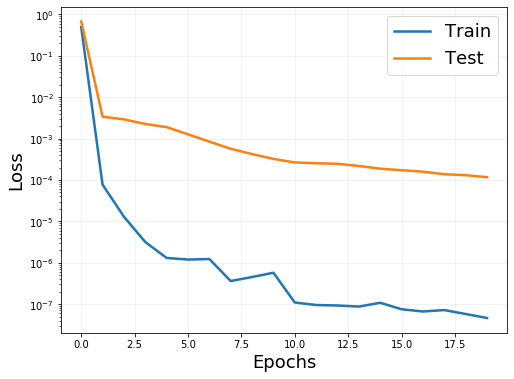

In [15]:
plt.figure(figsize=(8,6))
plt.plot(train_loss, label="Train", linewidth=2.5)
plt.plot(test_loss, label="Test", linewidth=2.5)
plt.grid("on", alpha=0.2)
plt.legend(fontsize=18)
plt.yscale("log")
plt.xlabel("Epochs", fontsize=18)
plt.ylabel("Loss", fontsize=18)
plt.show()

# Evaluating Results

In [16]:
def rmse(true, pred):
    return (((true-pred)**2).mean()**0.5).detach().cpu().numpy()

def l2_error(true, pred):
    return np.linalg.norm(pred.detach().cpu().numpy() - true.detach().cpu().numpy()) / np.linalg.norm(true.detach().cpu().numpy()) 

def compute_metrics(model, loader, mean=0.0, std=1.0):
    model.eval()
    y_ = []
    pred_ = []
    mean = torch.tensor(mean).to(device)
    std = torch.tensor(std).to(device)
    for x, y in iter(loader):
        x, y = x.to(device).float(), y.to(device).float()
        pred = model(x)
        y = y * std + mean
        pred = pred * std + mean
        y_.append(y)
        pred_.append(pred)
    y_ = torch.cat(y_, dim=0) 
    pred_ = torch.cat(pred_, dim=0)
    
    rmse_temp = rmse(y_[:,0], pred_[:,0])
    
    l2_error_temp = l2_error(y_[:,0], pred_[:,0])
    return rmse_temp, l2_error_temp

In [17]:
rmse_temp, l2_error_temp = compute_metrics(model, test_loader,  mean = output_mean, std = output_std)
print(f"Test Rmse of Temp: {rmse_temp}")
print(f"L2 Error  of Temp: {l2_error_temp}")

Test Rmse of Temp: 0.05960944225397827
L2 Error  of Temp: 0.0036383155038024703


In [18]:
rmse_temp, l2_error_temp = compute_metrics(model, train_loader,  mean = output_mean, std = output_std)
print(f"Train Rmse of Temp: {rmse_temp}")
print(f"L2 Error  of Temp: {l2_error_temp}")

Train Rmse of Temp: 0.0015442350804451795
L2 Error  of Temp: 0.00011089225777233648


# Saving Model

In [19]:
PATH = f"./saved_models/ice_model_time.pth"
torch.save(model.state_dict(), PATH)

In [20]:
output_mean

array([12.6070644])